# 🚀 Classification de Styles de Décoration - Entraînement Complet (Kaggle)

Ce notebook combine toutes les étapes nécessaires pour entraîner le modèle :
- **ÉTAPE 1** : Exploration du dataset
- **ÉTAPE 2** : Préparation des données (train/val split, augmentation)
- **ÉTAPE 3** : Construction du modèle MobileNetV2
- **ÉTAPE 4** : Entraînement du modèle

**Configuration :**
- **Taille d'image** : 256×256 pixels (au lieu de 224×224 pour plus de détails)
- **Architecture** : MobileNetV2 avec transfer learning

**Sorties :**
- `best_model.h5` : Meilleur modèle sauvegardé
- `training_history.csv` : Historique complet de l'entraînement
- `data_config.json` : Configuration utilisée
- `training_history.png` : Graphiques des courbes

Ces fichiers seront disponibles dans `/kaggle/working/` pour téléchargement.


In [ ]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

print(f"TensorFlow version: {tf.__version__}")


## Configuration Gpu (Critique Pour Éviter Crashes)


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU(s) détecté(s): {len(gpus)}")
    for gpu in gpus:
        print(f"   - {gpu.name}")
        # Activer la croissance dynamique de la mémoire
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except:
            pass
else:
    print("\n⚠️  Aucun GPU détecté")


## Configuration 1 : Mixed Precision (40-50% Ram Économisée)


In [ ]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f"\n✅ Mixed Precision activé : {policy.name}")
print(f"   Compute dtype: {policy.compute_dtype}")
print(f"   Variable dtype: {policy.variable_dtype}")
print(f"   💾 Économie RAM : ~40-50%")


## Chemins


In [ ]:
DATASET_PATH = Path("/kaggle/input/event-decoration-styles-dataset/dataset")  # À MODIFIER !
OUTPUT_DIR = Path("/kaggle/working")
OUTPUT_DIR.mkdir(exist_ok=True)

# Mapping des styles
STYLE_MAPPING = {
    'boheme': 'bohemian',
    'royal': 'royal',
    'minimaliste': 'minimalist',
    'rustique': 'rustic',
    'vintage': 'vintage',
    'moderne': 'modern',
    'industriel': 'industrial',
}


## Hyperparamètres Optimisés Pour Meilleure Accuracy


In [7]:
# - IMG_SIZE maintenant aligné avec la description: 256x256
# - FINETUNE_EPOCHS = nombre d'epochs SUPPLÉMENTAIRES de fine-tuning
# - TOTAL_EPOCHS = INITIAL_EPOCHS + FINETUNE_EPOCHS

IMG_SIZE = (256, 256)      # Aligné avec la description en haut du notebook
BATCH_SIZE = 16            # Gradients stables + mémoire raisonnable
SEED = 42
VAL_SPLIT = 0.2

TARGET_ACCURACY_MIN = 0.65  # 65% minimum
TARGET_ACCURACY_MAX = 0.75  # 75% idéal
MAX_PHASES = 6  # Maximum de phases de fine-tuning (sécurité)

# Phase 1 : Transfer Learning (base gelée) - AMÉLIORÉE
INITIAL_EPOCHS = 25
INITIAL_LR = 0.001         # LR standard pour entraîner la tête

# Phase 2 : Fine-tuning (base partiellement dégelée) - AMÉLIORÉE
FINETUNE_EPOCHS = 30
FINETUNE_LR = 0.0001       # LR plus faible pour ne pas détruire les poids ImageNet

# Phases supplémentaires (automatiques)
ADDITIONAL_PHASE_EPOCHS = 25  # Epochs par phase supplémentaire

print(f"\n📁 Dataset path: {DATASET_PATH}")
print(f"📁 Output dir: {OUTPUT_DIR}")
print(f"✅ Dataset existe: {DATASET_PATH.exists()}")

print(f"\n⚙️  Configuration:")
print(f"   Image size: {IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Mixed precision: Activé")
print(f"   Croissance dynamique GPU: Activé")
print(f"   Epochs Phase 1: {INITIAL_EPOCHS}")
print(f"   Epochs Phase 2 (supplémentaires): {FINETUNE_EPOCHS}")
print(f"   Epochs par phase supplémentaire: {ADDITIONAL_PHASE_EPOCHS}")
print(f"   Objectif accuracy: {TARGET_ACCURACY_MIN*100:.0f}-{TARGET_ACCURACY_MAX*100:.0f}%")
print(f"   Phases maximum: {MAX_PHASES}")

# Afficher utilisation mémoire si possible
if gpus:
    try:
        gpu_memory = tf.config.experimental.get_memory_info('GPU:0')
        print(f"\n💾 Mémoire GPU initiale:")
        print(f"   Actuelle: {gpu_memory['current'] / 1e9:.2f} GB")
    except:
        pass


TensorFlow version: 2.18.0

✅ GPU(s) détecté(s): 2
   - /physical_device:GPU:0
   - /physical_device:GPU:1

✅ Mixed Precision activé : mixed_float16
   Compute dtype: float16
   Variable dtype: float32
   💾 Économie RAM : ~40-50%

📁 Dataset path: /kaggle/input/event-decoration-styles-dataset/dataset
📁 Output dir: /kaggle/working
✅ Dataset existe: True

⚙️  Configuration:
   Image size: (256, 256)
   Batch size: 16
   Mixed precision: Activé
   Croissance dynamique GPU: Activé
   Epochs Phase 1: 25
   Epochs Phase 2 (supplémentaires): 30
   Epochs par phase supplémentaire: 25
   Objectif accuracy: 65-75%
   Phases maximum: 6

💾 Mémoire GPU initiale:
   Actuelle: 0.01 GB


## Vérification Rapide Du Dataset


In [8]:
if not DATASET_PATH.exists():
    raise ValueError(f"Dataset non trouvé : {DATASET_PATH}")

style_dirs = [d for d in DATASET_PATH.iterdir() if d.is_dir()]
print(f"\n📂 {len(style_dirs)} dossiers de styles détectés:\n")

styles_info = {}
for style_dir in sorted(style_dirs):
    style_name = style_dir.name
    image_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}
    image_files = [f for f in style_dir.iterdir() 
                  if f.suffix in image_extensions and f.is_file()]
    english_name = STYLE_MAPPING.get(style_name, style_name)
    styles_info[style_name] = {
        'english_name': english_name,
        'image_count': len(image_files)
    }
    print(f"   {style_name:15s} → {english_name:15s} : {len(image_files):5d} images")

total_images = sum(info['image_count'] for info in styles_info.values())
print(f"\n✅ Total: {total_images:,} images")

CLASS_NAMES = [STYLE_MAPPING.get(name, name) for name in sorted(styles_info.keys())]
NUM_CLASSES = len(CLASS_NAMES)
print(f"✅ {NUM_CLASSES} classes: {CLASS_NAMES}")



📂 7 dossiers de styles détectés:

   boheme          → bohemian        :  6576 images
   industriel      → industrial      :  4185 images
   minimaliste     → minimalist      :  5034 images
   moderne         → modern          :  6289 images
   royal           → royal           :  6163 images
   rustique        → rustic          :  6596 images
   vintage         → vintage         :  6489 images

✅ Total: 41,332 images
✅ 7 classes: ['bohemian', 'industrial', 'minimalist', 'modern', 'royal', 'rustic', 'vintage']


## Création Des Datasets Train/Validation


In [ ]:
print("\n🔄 Création des datasets...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    labels="inferred",
    label_mode="categorical",
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    labels="inferred",
    label_mode="categorical",
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Récupérer les noms de classes
class_names_raw = train_ds.class_names
class_names_en = [STYLE_MAPPING.get(name, name) for name in class_names_raw]

print(f"✅ Datasets créés:")
print(f"   Train batches: {len(train_ds)}")
print(f"   Validation batches: {len(val_ds)}")
print(f"   Classes détectées: {class_names_raw}")
print(f"   Classes mappées (EN): {class_names_en}")


## Optimisation Du Pipeline (Sans Cache)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds
    .prefetch(buffer_size=AUTOTUNE)
)

print("✅ Pipeline optimisé")



🔄 Création des datasets...
Found 41332 files belonging to 7 classes.
Using 33066 files for training.
Found 41332 files belonging to 7 classes.
Using 8266 files for validation.
✅ Datasets créés:
   Train batches: 2067
   Validation batches: 517
   Classes détectées: ['boheme', 'industriel', 'minimaliste', 'moderne', 'royal', 'rustique', 'vintage']
   Classes mappées (EN): ['bohemian', 'industrial', 'minimalist', 'modern', 'royal', 'rustic', 'vintage']
✅ Pipeline optimisé


## Construction Du Modèle - Version Finale Corrigée


In [10]:
def create_model(num_classes, img_size=(256, 256)):
    """
    Crée le modèle de classification de styles.
    VERSION CORRIGÉE : Preprocessing correct + architecture simplifiée mais efficace.
    """
    # Input
    inputs = keras.Input(shape=img_size + (3,))
    
    x = layers.Rescaling(1./255)(inputs)
    
    # MODÉRÉE pour éviter de déformer trop
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.08)(x)
    x = layers.RandomZoom(0.08)(x)
    
    x = x * 255.0
    
    x = preprocess_input(x)
    
    # Base MobileNetV2 (pré-entraîné, GELÉ au départ)
    base_model = MobileNetV2(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet',
        alpha=1.0
    )
    base_model.trainable = False
    
    x = base_model(x, training=False)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dropout modéré
    x = layers.Dropout(0.3)(x)
    
    # Plus petite = moins de risque de surapprentissage
    x = layers.Dense(256, activation='relu', name='fc1')(x)
    x = layers.Dropout(0.2)(x)  # Dropout après Dense
    
    # Classification finale
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = keras.Model(inputs, outputs, name='style_classifier')
    
    return model, base_model

# Créer le modèle
model, base_model = create_model(NUM_CLASSES, IMG_SIZE)

print("\n✅ Modèle créé (VERSION CORRIGÉE)")
print(f"   Total paramètres: {model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"   Paramètres entraînables: {trainable_params:,}")
print(f"   Paramètres gelés: {model.count_params() - trainable_params:,}")

print(f"\n✅ Base MobileNetV2 récupéré")
print(f"   Nom: {base_model.name}")
print(f"   Couches: {len(base_model.layers)}")
print(f"   Paramètres: {base_model.count_params():,}")

model.summary()



✅ Modèle créé (VERSION CORRIGÉE)
   Total paramètres: 2,587,719
   Paramètres entraînables: 329,735
   Paramètres gelés: 2,257,984

✅ Base MobileNetV2 récupéré
   Nom: mobilenetv2_1.00_224
   Couches: 154
   Paramètres: 2,257,984


Model: "style_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Sauvegarde De La Configuration


In [11]:
config = {
    "img_size": list(IMG_SIZE),
    "batch_size": BATCH_SIZE,
    "val_split": VAL_SPLIT,
    "seed": SEED,
    "class_names_raw": class_names_raw,
    "class_names_en": class_names_en,
    "num_classes": NUM_CLASSES,
    "initial_epochs": INITIAL_EPOCHS,
    "finetune_epochs": FINETUNE_EPOCHS,
    "initial_lr": INITIAL_LR,
    "finetune_lr": FINETUNE_LR,
}

config_path = OUTPUT_DIR / "data_config.json"
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print(f"✅ Configuration sauvegardée: {config_path}")


✅ Configuration sauvegardée: /kaggle/working/data_config.json


## Phase 1 : Entraînement Initial (Base Gelée)


In [ ]:
print("\n" + "=" * 80)
print("🚀 PHASE 1 : ENTRAÎNEMENT INITIAL")
print("=" * 80)
print(f"Epochs: {INITIAL_EPOCHS}")
print(f"Learning rate: {INITIAL_LR}")
print(f"Base MobileNetV2: GELÉE (trainable=False)")
print("=" * 80 + "\n")


## Métrique Top-K Compatible Mixed Precision


In [12]:
# Créer une métrique personnalisée compatible avec float16
@tf.keras.utils.register_keras_serializable()
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k=3, name='top_k_categorical_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.k = k
        self.top_k_acc = self.add_weight(name='top_k_acc', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convertir en float32 pour le calcul
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        # Obtenir les indices des vraies classes (one-hot -> indices)
        y_true_indices = tf.argmax(y_true, axis=1)
        
        # Calculer top-k accuracy
        top_k = tf.nn.in_top_k(y_true_indices, y_pred, self.k)
        top_k = tf.cast(top_k, tf.float32)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            top_k = tf.multiply(top_k, sample_weight)
            self.count.assign_add(tf.reduce_sum(sample_weight))
        else:
            self.count.assign_add(tf.cast(tf.size(top_k), tf.float32))
        
        self.top_k_acc.assign_add(tf.reduce_sum(top_k))
    
    def result(self):
        return tf.divide(self.top_k_acc, self.count)
    
    def reset_state(self):
        self.top_k_acc.assign(0.0)
        self.count.assign(0.0)

# On utilise un LR fixe et laissons ReduceLROnPlateau le gérer
# (Un schedule ne peut pas être modifié par ReduceLROnPlateau)

# Compiler le modèle (Phase 1)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKAccuracy(k=3)]
)

# Callbacks pour Phase 1
callbacks_phase1 = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(OUTPUT_DIR / "model_phase1_best.h5"),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.CSVLogger(
        filename=str(OUTPUT_DIR / "history_phase1.csv"),
        append=False
    )
]

# Entraînement Phase 1
print("🏋️ Début de l'entraînement Phase 1...\n")

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks_phase1,
    verbose=1
)

# Résultats Phase 1
phase1_val_acc = max(history_phase1.history['val_accuracy'])
phase1_epoch = history_phase1.history['val_accuracy'].index(phase1_val_acc) + 1

print("\n" + "=" * 80)
print("📊 RÉSULTATS PHASE 1")
print("=" * 80)
print(f"Meilleure val accuracy: {phase1_val_acc:.4f} ({phase1_val_acc*100:.2f}%)")
print(f"Epoch: {phase1_epoch}")
print(f"Val loss: {history_phase1.history['val_loss'][phase1_epoch-1]:.4f}")
if 'top_k_categorical_accuracy' in history_phase1.history:
    print(f"Top-3 accuracy: {history_phase1.history['top_k_categorical_accuracy'][phase1_epoch-1]:.4f}")
print("=" * 80 + "\n")

# Sauvegarder le modèle Phase 1
model.save(OUTPUT_DIR / "model_phase1_final.h5")
print(f"✅ Modèle Phase 1 sauvegardé")

best_phase1_path = OUTPUT_DIR / "model_phase1_best.h5"
if best_phase1_path.exists():
    print(f"\n🔄 Chargement des MEILLEURS poids de Phase 1...")
    model.load_weights(best_phase1_path)
    print(f"✅ Meilleurs poids chargés (val_acc: {phase1_val_acc:.4f})")
    
    # Vérifier que les poids sont bien chargés
    eval_results = model.evaluate(val_ds, verbose=0)
    test_loss, test_acc = eval_results[0], eval_results[1]
    print(f"   Vérification: val_accuracy = {test_acc:.4f} (devrait être ~{phase1_val_acc:.4f})")
else:
    print(f"\n⚠️  Fichier {best_phase1_path} non trouvé, utilisation des poids finaux")



🚀 PHASE 1 : ENTRAÎNEMENT INITIAL
Epochs: 25
Learning rate: 0.001
Base MobileNetV2: GELÉE (trainable=False)

🏋️ Début de l'entraînement Phase 1...

Epoch 1/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2519 - loss: 1.8732 - top_k_categorical_accuracy: 0.5972
Epoch 1: val_accuracy improved from -inf to 0.32882, saving model to /kaggle/working/model_phase1_best.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 104s 45ms/step - accuracy: 0.2520 - loss: 1.8731 - top_k_categorical_accuracy: 0.5972 - val_accuracy: 0.3288 - val_loss: 1.6916 - val_top_k_categorical_accuracy: 0.6928 - learning_rate: 0.0010
Epoch 2/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3118 - loss: 1.7296 - top_k_categorical_accuracy: 0.6650
Epoch 2: val_accuracy improved from 0.32882 to 0.33813, saving model to /kaggle/working/model_phase1_best.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 98s 44ms/step - accuracy: 0.3118 - loss: 1.7296 - top_k_categorical_accuracy: 0.6650 - val_accuracy: 0.3381 - val_loss: 1.6791 - val_top_k_categorical_accuracy: 0.6898 - learning_rate: 0.0010
Epoch 3/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3232 - loss: 1.7038 - top_k_categorical_accuracy: 0.6869
Epoch 3: val_accuracy improved from 0.33813 to 0.34660, saving model to /kaggle/working/model_phase1_best.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 0.3232 - loss: 1.7038 - top_k_categorical_accuracy: 0.6869 - val_accuracy: 0.3466 - val_loss: 1.6657 - val_top_k_categorical_accuracy: 0.7053 - learning_rate: 0.0010
Epoch 4/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3282 - loss: 1.6856 - top_k_categorical_accuracy: 0.6894
Epoch 4: val_accuracy improved from 0.34660 to 0.34684, saving model to /kaggle/working/model_phase1_best.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 0.3282 - loss: 1.6856 - top_k_categorical_accuracy: 0.6894 - val_accuracy: 0.3468 - val_loss: 1.6519 - val_top_k_categorical_accuracy: 0.7066 - learning_rate: 0.0010
Epoch 5/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3290 - loss: 1.6804 - top_k_categorical_accuracy: 0.6940
Epoch 5: val_accuracy improved from 0.34684 to 0.36051, saving model to /kaggle/working/model_phase1_best.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 0.3290 - loss: 1.6804 - top_k_categorical_accuracy: 0.6940 - val_accuracy: 0.3605 - val_loss: 1.6285 - val_top_k_categorical_accuracy: 0.7199 - learning_rate: 0.0010
Epoch 6/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3354 - loss: 1.6721 - top_k_categorical_accuracy: 0.6929
Epoch 6: val_accuracy improved from 0.36051 to 0.36559, saving model to /kaggle/working/model_phase1_best.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 0.3354 - loss: 1.6721 - top_k_categorical_accuracy: 0.6929 - val_accuracy: 0.3656 - val_loss: 1.6297 - val_top_k_categorical_accuracy: 0.7220 - learning_rate: 0.0010
Epoch 7/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3406 - loss: 1.6697 - top_k_categorical_accuracy: 0.6958
Epoch 7: val_accuracy did not improve from 0.36559
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 98s 44ms/step - accuracy: 0.3406 - loss: 1.6697 - top_k_categorical_accuracy: 0.6958 - val_accuracy: 0.3576 - val_loss: 1.6445 - val_top_k_categorical_accuracy: 0.7082 - learning_rate: 0.0010
Epoch 8/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3351 - loss: 1.6630 - top_k_categorical_accuracy: 0.6978
Epoch 8: val_accuracy did not improve from 0.36559

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 100s 45ms/step - accuracy: 0.3351 - loss: 1.6630 - top_k_categorical_accuracy: 0.6978 - val_

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 98s 44ms/step - accuracy: 0.3401 - loss: 1.6499 - top_k_categorical_accuracy: 0.7063 - val_accuracy: 0.3673 - val_loss: 1.6227 - val_top_k_categorical_accuracy: 0.7204 - learning_rate: 5.0000e-04
Epoch 10/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3470 - loss: 1.6330 - top_k_categorical_accuracy: 0.7117
Epoch 10: val_accuracy did not improve from 0.36729
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 98s 44ms/step - accuracy: 0.3470 - loss: 1.6330 - top_k_categorical_accuracy: 0.7117 - val_accuracy: 0.3610 - val_loss: 1.6186 - val_top_k_categorical_accuracy: 0.7228 - learning_rate: 5.0000e-04
Epoch 11/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3512 - loss: 1.6309 - top_k_categorical_accuracy: 0.7088
Epoch 11: val_accuracy did not improve from 0.36729
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 98s 44ms/step - accuracy: 0.3512 - loss: 1.6309 - top_k_categorical_accuracy: 0.7088 - val_accuracy: 0.3610 - val_loss: 1.6183 - val_top_k_categorical_accura

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 101s 45ms/step - accuracy: 0.3526 - loss: 1.6232 - top_k_categorical_accuracy: 0.7148 - val_accuracy: 0.3693 - val_loss: 1.6080 - val_top_k_categorical_accuracy: 0.7285 - learning_rate: 5.0000e-04
Epoch 15/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3509 - loss: 1.6220 - top_k_categorical_accuracy: 0.7154
Epoch 15: val_accuracy did not improve from 0.36934
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 99s 45ms/step - accuracy: 0.3509 - loss: 1.6220 - top_k_categorical_accuracy: 0.7154 - val_accuracy: 0.3667 - val_loss: 1.6009 - val_top_k_categorical_accuracy: 0.7271 - learning_rate: 5.0000e-04
Epoch 16/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3523 - loss: 1.6171 - top_k_categorical_accuracy: 0.7138
Epoch 16: val_accuracy did not improve from 0.36934
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 99s 44ms/step - accuracy: 0.3523 - loss: 1.6171 - top_k_categorical_accuracy: 0.7138 - val_accuracy: 0.3689 - val_loss: 1.6034 - val_top_k_categorical_accur

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 98s 44ms/step - accuracy: 0.3614 - loss: 1.5987 - top_k_categorical_accuracy: 0.7234 - val_accuracy: 0.3706 - val_loss: 1.5955 - val_top_k_categorical_accuracy: 0.7259 - learning_rate: 1.2500e-04
Epoch 23/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3690 - loss: 1.5863 - top_k_categorical_accuracy: 0.7266
Epoch 23: val_accuracy improved from 0.37055 to 0.37116, saving model to /kaggle/working/model_phase1_best.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 98s 44ms/step - accuracy: 0.3690 - loss: 1.5863 - top_k_categorical_accuracy: 0.7266 - val_accuracy: 0.3712 - val_loss: 1.5924 - val_top_k_categorical_accuracy: 0.7299 - learning_rate: 1.2500e-04
Epoch 24/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3629 - loss: 1.5931 - top_k_categorical_accuracy: 0.7255
Epoch 24: val_accuracy did not improve from 0.37116
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 0.3629 - loss: 1.5930 - top_k_categorical_accuracy: 0.7255 - val_accuracy: 0.3702 - val_loss: 1.5943 - val_top_k_categorical_accuracy: 0.7314 - learning_rate: 1.2500e-04
Epoch 25/25
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3642 - loss: 1.5957 - top_k_categorical_accuracy: 0.7273
Epoch 25: val_accuracy did not improve from 0.37116
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 0.3642 - loss: 1.5957 - top_k_categorical_accuracy: 0.7273 - val_accuracy: 0.3683 - val_loss: 1.5945 - val_top_k_categorical_accura


📊 RÉSULTATS PHASE 1
Meilleure val accuracy: 0.3712 (37.12%)
Epoch: 23
Val loss: 1.5924
Top-3 accuracy: 0.7272

✅ Modèle Phase 1 sauvegardé

🔄 Chargement des MEILLEURS poids de Phase 1...
✅ Meilleurs poids chargés (val_acc: 0.3712)
   Vérification: val_accuracy = 0.3712 (devrait être ~0.3712)


## Phase 2 : Fine-Tuning - Version Corrigée


In [ ]:
print("\n" + "=" * 80)
print("🔥 PHASE 2 : FINE-TUNING (VERSION CORRIGÉE)")
print("=" * 80)

best_phase1_path = OUTPUT_DIR / "model_phase1_best.h5"
if best_phase1_path.exists():
    print(f"\n🔄 Chargement des MEILLEURS poids de Phase 1...")
    model.load_weights(best_phase1_path)
    eval_results = model.evaluate(val_ds, verbose=0)
    verify_loss, verify_acc = eval_results[0], eval_results[1]
    print(f"✅ Meilleurs poids Phase 1 chargés")
    print(f"   Val Accuracy vérifiée: {verify_acc:.4f} ({verify_acc*100:.2f}%)")
    print(f"   Devrait correspondre à Phase 1 best: {phase1_val_acc:.4f} ({phase1_val_acc*100:.2f}%)")
    
    if abs(verify_acc - phase1_val_acc) > 0.02:
        print(f"   ⚠️  ATTENTION: Différence importante détectée!")
else:
    print(f"\n⚠️  Fichier {best_phase1_path} non trouvé")
    print("   Phase 2 commencera avec les poids finaux de Phase 1")

print(f"\n✅ Base MobileNetV2 disponible : {base_model.name}")
print(f"   Couches : {len(base_model.layers)}")


## Dégel Plus Conservateur (Moins De Couches)


In [13]:
base_model.trainable = True

# Phase 2 : Dégeler progressivement (moins conservateur que avant)
FREEZE_UNTIL = 130

frozen_count = 0
trainable_count = 0

for i, layer in enumerate(base_model.layers):
    if i < FREEZE_UNTIL:
        layer.trainable = False
        frozen_count += 1
    else:
        layer.trainable = True
        trainable_count += 1

print(f"\n📊 Configuration Fine-Tuning (AJUSTÉE):")
print(f"   Couches gelées (0-{FREEZE_UNTIL-1}): {frozen_count}")
print(f"   Couches dégelées ({FREEZE_UNTIL}+): {trainable_count}")

# Vérification
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
total_params = model.count_params()

print(f"\n📊 Paramètres après dégel:")
print(f"   Total: {total_params:,}")
print(f"   Entraînables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"   Attendu: 400,000-600,000 paramètres (optimal)")

if trainable_params > 1000000:
    print(f"\n⚠️  ATTENTION: Trop de paramètres entraînables ({trainable_params:,})")
    print("   Risque d'instabilité - considérer FREEZE_UNTIL = 135")
elif trainable_params < 200000:
    print(f"\n⚠️  ATTENTION: Pas assez de paramètres entraînables ({trainable_params:,})")
    print("   Considérer FREEZE_UNTIL = 125")
elif 200000 <= trainable_params <= 600000:
    print("\n✅ Configuration OPTIMALE pour fine-tuning")
else:
    print("\n✅ Configuration acceptable")

# On utilise un LR fixe et laissons ReduceLROnPlateau le gérer
# (Un schedule ne peut pas être modifié par ReduceLROnPlateau)

# Recompiler avec LR fixe
print(f"\n🔧 Recompilation avec LR = {FINETUNE_LR}")

# Utiliser la même métrique personnalisée
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINETUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKAccuracy(k=3)]
)

print("✅ Modèle recompilé")

# Callbacks Phase 2 avec patience augmentée
callbacks_phase2 = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(OUTPUT_DIR / "best_model_finetuned.h5"),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.CSVLogger(
        filename=str(OUTPUT_DIR / "history_phase2.csv"),
        append=False
    )
]

# Entraînement
print("\n" + "=" * 80)
print("🚀 DÉBUT DU FINE-TUNING")
print("=" * 80)
print(f"Epochs: {FINETUNE_EPOCHS}")
print(f"Learning rate: {FINETUNE_LR}")
print(f"Paramètres entraînables: {trainable_params:,}")
print(f"ATTENDU: Val Accuracy 70-85%")
print("=" * 80 + "\n")

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINETUNE_EPOCHS,
    initial_epoch=INITIAL_EPOCHS,
    callbacks=callbacks_phase2,
    verbose=1
)

print("\n✅ FINE-TUNING PHASE 2 TERMINÉ !")

best_phase2_path = OUTPUT_DIR / "best_model_finetuned.h5"
if best_phase2_path.exists():
    print(f"\n🔄 Chargement des MEILLEURS poids de Phase 2...")
    model.load_weights(best_phase2_path)
    eval_results = model.evaluate(val_ds, verbose=0)
    verify_loss, verify_acc = eval_results[0], eval_results[1]
    print(f"✅ Meilleurs poids chargés: val_acc = {verify_acc:.4f} ({verify_acc*100:.2f}%)")
    
    # Sauvegarder pour Phase 3
    model.save(OUTPUT_DIR / "model_phase2_best_loaded.h5")
    print(f"✅ Modèle sauvegardé pour Phase 3")



🔥 PHASE 2 : FINE-TUNING (VERSION CORRIGÉE)

🔄 Chargement des MEILLEURS poids de Phase 1...
✅ Meilleurs poids Phase 1 chargés
   Val Accuracy vérifiée: 0.3712 (37.12%)
   Devrait correspondre à Phase 1 best: 0.3712 (37.12%)

✅ Base MobileNetV2 disponible : mobilenetv2_1.00_224
   Couches : 154

📊 Configuration Fine-Tuning (AJUSTÉE):
   Couches gelées (0-129): 130
   Couches dégelées (130+): 24

📊 Paramètres après dégel:
   Total: 2,587,719
   Entraînables: 1,689,735 (65.3%)
   Attendu: 400,000-600,000 paramètres (optimal)

⚠️  ATTENTION: Trop de paramètres entraînables (1,689,735)
   Risque d'instabilité - considérer FREEZE_UNTIL = 135

🔧 Recompilation avec LR = 0.0001
✅ Modèle recompilé

🚀 DÉBUT DU FINE-TUNING
Epochs: 30
Learning rate: 0.0001
Paramètres entraînables: 1,689,735
ATTENDU: Val Accuracy 70-85%

Epoch 26/30
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3259 - loss: 1.7129 - top_k_categorical_accuracy: 0.6739
Epoch 26: val_accuracy improved from -inf to 0.33487, 

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 127s 54ms/step - accuracy: 0.3259 - loss: 1.7128 - top_k_categorical_accuracy: 0.6739 - val_accuracy: 0.3349 - val_loss: 1.6972 - val_top_k_categorical_accuracy: 0.7035 - learning_rate: 1.0000e-04
Epoch 27/30
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3642 - loss: 1.5892 - top_k_categorical_accuracy: 0.7339
Epoch 27: val_accuracy improved from 0.33487 to 0.38761, saving model to /kaggle/working/best_model_finetuned.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 116s 53ms/step - accuracy: 0.3642 - loss: 1.5892 - top_k_categorical_accuracy: 0.7339 - val_accuracy: 0.3876 - val_loss: 1.5689 - val_top_k_categorical_accuracy: 0.7366 - learning_rate: 1.0000e-04
Epoch 28/30
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3963 - loss: 1.5159 - top_k_categorical_accuracy: 0.7630
Epoch 28: val_accuracy did not improve from 0.38761
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 116s 52ms/step - accuracy: 0.3963 - loss: 1.5159 - top_k_categorical_accuracy: 0.7630 - val_accuracy: 0.3810 - val_loss: 1.5688 - val_top_k_categorical_accuracy: 0.7479 - learning_rate: 1.0000e-04
Epoch 29/30
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4121 - loss: 1.4623 - top_k_categorical_accuracy: 0.7803
Epoch 29: val_accuracy did not improve from 0.38761
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 114s 52ms/step - accuracy: 0.4121 - loss: 1.4623 - top_k_categorical_accuracy: 0.7803 - val_accuracy: 0.3591 - val_loss: 1.6198 - val_top_k_categorical_acc

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.4227 - loss: 1.4203 - top_k_categorical_accuracy: 0.7961 - val_accuracy: 0.3997 - val_loss: 1.5078 - val_top_k_categorical_accuracy: 0.7779 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.

✅ FINE-TUNING PHASE 2 TERMINÉ !

🔄 Chargement des MEILLEURS poids de Phase 2...


✅ Meilleurs poids chargés: val_acc = 0.3997 (39.97%)
✅ Modèle sauvegardé pour Phase 3


In [14]:
# Continue jusqu'à atteindre 80-85% accuracy

# Récupérer l'accuracy actuelle
current_acc = max(history_phase2.history["val_accuracy"])
current_epoch = INITIAL_EPOCHS + FINETUNE_EPOCHS

# Historiques combinés pour tracking
all_histories = {
    'phase1': history_phase1,
    'phase2': history_phase2
}

# Configuration des phases supplémentaires
# Chaque phase dégèle plus de couches et utilise un LR plus bas
phase_configs = [
    {'freeze_until': 120, 'lr_multiplier': 0.5, 'name': 'Phase 3'},
    {'freeze_until': 110, 'lr_multiplier': 0.3, 'name': 'Phase 4'},
    {'freeze_until': 100, 'lr_multiplier': 0.2, 'name': 'Phase 5'},
    {'freeze_until': 90,  'lr_multiplier': 0.1, 'name': 'Phase 6'},
]

phase_num = 3
best_model_path = OUTPUT_DIR / "best_model_finetuned.h5"

print("\n" + "=" * 80)
print("🔄 SYSTÈME DE PHASES AUTOMATIQUES")
print("=" * 80)
print(f"Accuracy actuelle: {current_acc:.4f} ({current_acc*100:.2f}%)")
print(f"Objectif: {TARGET_ACCURACY_MIN*100:.0f}-{TARGET_ACCURACY_MAX*100:.0f}%")
print("=" * 80)

# Continuer tant que l'accuracy est < 80% et qu'on n'a pas atteint le max de phases
while current_acc < TARGET_ACCURACY_MIN and phase_num <= MAX_PHASES:
    phase_config = phase_configs[phase_num - 3]  # phase_num commence à 3
    
    print(f"\n{'='*80}")
    print(f"🔄 {phase_config['name']} : Fine-tuning Progressif")
    print(f"{'='*80}")
    print(f"Accuracy avant {phase_config['name']}: {current_acc:.4f} ({current_acc*100:.2f}%)")
    print(f"Objectif: {TARGET_ACCURACY_MIN*100:.0f}%")
    print(f"{'='*80}\n")
    
    # Charger le meilleur modèle de la phase précédente
    if best_model_path.exists():
        model.load_weights(best_model_path)
        print(f"✅ Meilleurs poids de la phase précédente chargés")
    
    # Dégeler plus de couches
    base_model.trainable = True
    FREEZE_UNTIL = phase_config['freeze_until']
    
    frozen_count = 0
    trainable_count = 0
    
    for i, layer in enumerate(base_model.layers):
        if i < FREEZE_UNTIL:
            layer.trainable = False
            frozen_count += 1
        else:
            layer.trainable = True
            trainable_count += 1
    
    print(f"\n📊 Configuration {phase_config['name']}:")
    print(f"   Couches gelées: {frozen_count}")
    print(f"   Couches dégelées: {trainable_count}")
    
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   Paramètres entraînables: {trainable_params:,}")
    
    # LR encore plus bas (progressif)
    current_lr = FINETUNE_LR * phase_config['lr_multiplier']
    print(f"   Learning Rate: {current_lr:.6f}")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=current_lr),
        loss="categorical_crossentropy",
        metrics=["accuracy", TopKAccuracy(k=3)],
    )
    
    # Callbacks pour cette phase
    phase_best_path = OUTPUT_DIR / f"best_model_phase{phase_num}.h5"
    callbacks_phase = [
        keras.callbacks.ModelCheckpoint(
            filepath=str(phase_best_path),
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=12,  # Plus de patience pour phases avancées
            restore_best_weights=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=6,  # Plus de patience
            min_lr=1e-8,  # LR minimum très bas
            verbose=1,
        ),
        keras.callbacks.CSVLogger(
            filename=str(OUTPUT_DIR / f"history_phase{phase_num}.csv"),
            append=False,
        ),
    ]
    
    # Calculer les epochs
    phase_start_epoch = current_epoch
    phase_end_epoch = current_epoch + ADDITIONAL_PHASE_EPOCHS
    
    print(f"\n🚀 Début {phase_config['name']} (LR={current_lr:.6f}, Epochs {phase_start_epoch+1}-{phase_end_epoch})...\n")
    
    history_phase = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=phase_end_epoch,
        initial_epoch=phase_start_epoch,
        callbacks=callbacks_phase,
        verbose=1,
    )
    
    # Mettre à jour l'accuracy
    phase_best_acc = max(history_phase.history["val_accuracy"])
    current_epoch = phase_end_epoch
    
    print(f"\n✅ {phase_config['name']} terminée: val_acc = {phase_best_acc:.4f} ({phase_best_acc*100:.2f}%)")
    
    # Charger les meilleurs poids de cette phase
    if phase_best_path.exists():
        model.load_weights(phase_best_path)
        # Mettre à jour le meilleur modèle global
        model.save(best_model_path)
        print(f"✅ Meilleurs poids {phase_config['name']} sauvegardés comme modèle global")
    
    # Sauvegarder l'historique
    all_histories[f'phase{phase_num}'] = history_phase
    
    # Mettre à jour l'accuracy actuelle
    current_acc = phase_best_acc
    
    # Vérifier si on a atteint l'objectif
    if current_acc >= TARGET_ACCURACY_MIN:
        print(f"\n🎉 🎉 🎉 OBJECTIF ATTEINT ! 🎉 🎉 🎉")
        print(f"   Accuracy finale: {current_acc:.4f} ({current_acc*100:.2f}%)")
        print(f"   Objectif: {TARGET_ACCURACY_MIN*100:.0f}%")
        break
    
    phase_num += 1

# Résultat final
print(f"\n{'='*80}")
print(f"🏁 FIN DU SYSTÈME DE PHASES AUTOMATIQUES")
print(f"{'='*80}")
print(f"Accuracy finale: {current_acc:.4f} ({current_acc*100:.2f}%)")
print(f"Objectif: {TARGET_ACCURACY_MIN*100:.0f}-{TARGET_ACCURACY_MAX*100:.0f}%")
if current_acc >= TARGET_ACCURACY_MIN:
    print(f"✅ ✅ ✅ SUCCÈS : Objectif atteint !")
elif current_acc >= 0.75:
    print(f"✅ BON : Proche de l'objectif")
else:
    print(f"⚠️  CONTINUER : Encore en dessous de l'objectif")
print(f"{'='*80}")

# Mettre à jour les variables pour compatibilité avec le reste du code
phase2_val_acc = current_acc
history_phase2 = all_histories.get(f'phase{phase_num-1}', history_phase2)



🔄 SYSTÈME DE PHASES AUTOMATIQUES
Accuracy actuelle: 0.3997 (39.97%)
Objectif: 65-75%

🔄 Phase 3 : Fine-tuning Progressif
Accuracy avant Phase 3: 0.3997 (39.97%)
Objectif: 65%

✅ Meilleurs poids de la phase précédente chargés

📊 Configuration Phase 3:
   Couches gelées: 120
   Couches dégelées: 34
   Paramètres entraînables: 1,954,631
   Learning Rate: 0.000050

🚀 Début Phase 3 (LR=0.000050, Epochs 56-80)...

Epoch 56/80
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4323 - loss: 1.3944 - top_k_categorical_accuracy: 0.8064
Epoch 56: val_accuracy improved from -inf to 0.39136, saving model to /kaggle/working/best_model_phase3.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 136s 57ms/step - accuracy: 0.4323 - loss: 1.3944 - top_k_categorical_accuracy: 0.8064 - val_accuracy: 0.3914 - val_loss: 1.5947 - val_top_k_categorical_accuracy: 0.7556 - learning_rate: 5.0000e-05
Epoch 57/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4563 - loss: 1.3223 - top_k_categorical_accuracy: 0.8281
Epoch 57: val_accuracy improved from 0.39136 to 0.39910, saving model to /kaggle/working/best_model_phase3.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.4563 - loss: 1.3223 - top_k_categorical_accuracy: 0.8281 - val_accuracy: 0.3991 - val_loss: 1.5193 - val_top_k_categorical_accuracy: 0.7792 - learning_rate: 5.0000e-05
Epoch 58/80
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4636 - loss: 1.2880 - top_k_categorical_accuracy: 0.8408
Epoch 58: val_accuracy improved from 0.39910 to 0.41592, saving model to /kaggle/working/best_model_phase3.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.4636 - loss: 1.2880 - top_k_categorical_accuracy: 0.8408 - val_accuracy: 0.4159 - val_loss: 1.4817 - val_top_k_categorical_accuracy: 0.7865 - learning_rate: 5.0000e-05
Epoch 59/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4870 - loss: 1.2362 - top_k_categorical_accuracy: 0.8554
Epoch 59: val_accuracy improved from 0.41592 to 0.41870, saving model to /kaggle/working/best_model_phase3.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.4870 - loss: 1.2362 - top_k_categorical_accuracy: 0.8554 - val_accuracy: 0.4187 - val_loss: 1.4517 - val_top_k_categorical_accuracy: 0.8016 - learning_rate: 5.0000e-05
Epoch 60/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4897 - loss: 1.2169 - top_k_categorical_accuracy: 0.8613
Epoch 60: val_accuracy improved from 0.41870 to 0.42173, saving model to /kaggle/working/best_model_phase3.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 125s 57ms/step - accuracy: 0.4897 - loss: 1.2169 - top_k_categorical_accuracy: 0.8613 - val_accuracy: 0.4217 - val_loss: 1.4460 - val_top_k_categorical_accuracy: 0.8095 - learning_rate: 5.0000e-05
Epoch 61/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4958 - loss: 1.1778 - top_k_categorical_accuracy: 0.8766
Epoch 61: val_accuracy did not improve from 0.42173
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 125s 57ms/step - accuracy: 0.4958 - loss: 1.1778 - top_k_categorical_accuracy: 0.8766 - val_accuracy: 0.4084 - val_loss: 1.4933 - val_top_k_categorical_accuracy: 0.8085 - learning_rate: 5.0000e-05
Epoch 62/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5106 - loss: 1.1439 - top_k_categorical_accuracy: 0.8839
Epoch 62: val_accuracy did not improve from 0.42173
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 124s 57ms/step - accuracy: 0.5106 - loss: 1.1439 - top_k_categorical_accuracy: 0.8839 - val_accuracy: 0.3862 - val_loss: 1.6728 - val_top_k_categorical_acc

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.5319 - loss: 1.0737 - top_k_categorical_accuracy: 0.9024 - val_accuracy: 0.4231 - val_loss: 1.4769 - val_top_k_categorical_accuracy: 0.8258 - learning_rate: 5.0000e-05
Epoch 66/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5375 - loss: 1.0518 - top_k_categorical_accuracy: 0.9091
Epoch 66: val_accuracy did not improve from 0.42306

Epoch 66: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.5375 - loss: 1.0518 - top_k_categorical_accuracy: 0.9091 - val_accuracy: 0.4106 - val_loss: 1.5446 - val_top_k_categorical_accuracy: 0.8162 - learning_rate: 5.0000e-05
Epoch 67/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5533 - loss: 1.0141 - top_k_categorical_accuracy: 0.9176
Epoch 67: val_accuracy improved from 0.42306 to 0.42524, saving model to /kaggle/working/best_model_phase3.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.5533 - loss: 1.0141 - top_k_categorical_accuracy: 0.9176 - val_accuracy: 0.4252 - val_loss: 1.4928 - val_top_k_categorical_accuracy: 0.8419 - learning_rate: 2.5000e-05
Epoch 68/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5512 - loss: 0.9988 - top_k_categorical_accuracy: 0.9200
Epoch 68: val_accuracy improved from 0.42524 to 0.43552, saving model to /kaggle/working/best_model_phase3.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.5512 - loss: 0.9988 - top_k_categorical_accuracy: 0.9200 - val_accuracy: 0.4355 - val_loss: 1.4660 - val_top_k_categorical_accuracy: 0.8402 - learning_rate: 2.5000e-05
Epoch 69/80
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5687 - loss: 0.9633 - top_k_categorical_accuracy: 0.9261
Epoch 69: val_accuracy did not improve from 0.43552
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.5687 - loss: 0.9633 - top_k_categorical_accuracy: 0.9261 - val_accuracy: 0.4122 - val_loss: 1.6423 - val_top_k_categorical_accuracy: 0.8160 - learning_rate: 2.5000e-05
Epoch 70/80
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5756 - loss: 0.9468 - top_k_categorical_accuracy: 0.9331
Epoch 70: val_accuracy improved from 0.43552 to 0.43612, saving model to /kaggle/working/best_model_phase3.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.5756 - loss: 0.9468 - top_k_categorical_accuracy: 0.9331 - val_accuracy: 0.4361 - val_loss: 1.5067 - val_top_k_categorical_accuracy: 0.8450 - learning_rate: 2.5000e-05
Epoch 71/80
2066/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5768 - loss: 0.9419 - top_k_categorical_accuracy: 0.9350
Epoch 71: val_accuracy did not improve from 0.43612
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.5768 - loss: 0.9419 - top_k_categorical_accuracy: 0.9350 - val_accuracy: 0.4290 - val_loss: 1.5227 - val_top_k_categorical_accuracy: 0.8418 - learning_rate: 2.5000e-05
Epoch 72/80
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5796 - loss: 0.9305 - top_k_categorical_accuracy: 0.9351
Epoch 72: val_accuracy did not improve from 0.43612

Epoch 72: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.5796 - loss: 0.9305 - top_k_categorical_accuracy

✅ Meilleurs poids Phase 3 sauvegardés comme modèle global

🔄 Phase 4 : Fine-tuning Progressif
Accuracy avant Phase 4: 0.4361 (43.61%)
Objectif: 65%

✅ Meilleurs poids de la phase précédente chargés

📊 Configuration Phase 4:
   Couches gelées: 110
   Couches dégelées: 44
   Paramètres entraînables: 2,072,903
   Learning Rate: 0.000030

🚀 Début Phase 4 (LR=0.000030, Epochs 81-105)...

Epoch 81/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5532 - loss: 1.0081 - top_k_categorical_accuracy: 0.9165
Epoch 81: val_accuracy improved from -inf to 0.43080, saving model to /kaggle/working/best_model_phase4.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 149s 63ms/step - accuracy: 0.5532 - loss: 1.0081 - top_k_categorical_accuracy: 0.9165 - val_accuracy: 0.4308 - val_loss: 1.5272 - val_top_k_categorical_accuracy: 0.8361 - learning_rate: 3.0000e-05
Epoch 82/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5623 - loss: 0.9815 - top_k_categorical_accuracy: 0.9237
Epoch 82: val_accuracy did not improve from 0.43080
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.5623 - loss: 0.9815 - top_k_categorical_accuracy: 0.9237 - val_accuracy: 0.4239 - val_loss: 1.5202 - val_top_k_categorical_accuracy: 0.8404 - learning_rate: 3.0000e-05
Epoch 83/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5700 - loss: 0.9455 - top_k_categorical_accuracy: 0.9300
Epoch 83: val_accuracy improved from 0.43080 to 0.43334, saving model to /kaggle/working/best_model_phase4.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.5700 - loss: 0.9455 - top_k_categorical_accuracy: 0.9300 - val_accuracy: 0.4333 - val_loss: 1.4812 - val_top_k_categorical_accuracy: 0.8435 - learning_rate: 3.0000e-05
Epoch 84/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5729 - loss: 0.9470 - top_k_categorical_accuracy: 0.9330
Epoch 84: val_accuracy did not improve from 0.43334
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.5729 - loss: 0.9470 - top_k_categorical_accuracy: 0.9330 - val_accuracy: 0.4331 - val_loss: 1.5172 - val_top_k_categorical_accuracy: 0.8426 - learning_rate: 3.0000e-05
Epoch 85/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5839 - loss: 0.9152 - top_k_categorical_accuracy: 0.9385
Epoch 85: val_accuracy did not improve from 0.43334
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.5839 - loss: 0.9152 - top_k_categorical_accuracy: 0.9385 - val_accuracy: 0.4298 - val_loss: 1.5269 - val_top_k_categorical_a

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 137s 63ms/step - accuracy: 0.6098 - loss: 0.8363 - top_k_categorical_accuracy: 0.9508 - val_accuracy: 0.4375 - val_loss: 1.5614 - val_top_k_categorical_accuracy: 0.8545 - learning_rate: 1.5000e-05
Epoch 92/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6122 - loss: 0.8278 - top_k_categorical_accuracy: 0.9530
Epoch 92: val_accuracy did not improve from 0.43745
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 136s 62ms/step - accuracy: 0.6122 - loss: 0.8278 - top_k_categorical_accuracy: 0.9530 - val_accuracy: 0.4279 - val_loss: 1.6011 - val_top_k_categorical_accuracy: 0.8524 - learning_rate: 1.5000e-05
Epoch 93/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6201 - loss: 0.8097 - top_k_categorical_accuracy: 0.9569
Epoch 93: val_accuracy did not improve from 0.43745
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 136s 63ms/step - accuracy: 0.6201 - loss: 0.8097 - top_k_categorical_accuracy: 0.9569 - val_accuracy: 0.4318 - val_loss: 1.5733 - val_top_k_categorical_a

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.6219 - loss: 0.7897 - top_k_categorical_accuracy: 0.9595 - val_accuracy: 0.4383 - val_loss: 1.5912 - val_top_k_categorical_accuracy: 0.8624 - learning_rate: 7.5000e-06
Epoch 98/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6266 - loss: 0.7821 - top_k_categorical_accuracy: 0.9601
Epoch 98: val_accuracy did not improve from 0.43830
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 134s 61ms/step - accuracy: 0.6266 - loss: 0.7821 - top_k_categorical_accuracy: 0.9601 - val_accuracy: 0.4372 - val_loss: 1.6063 - val_top_k_categorical_accuracy: 0.8609 - learning_rate: 7.5000e-06
Epoch 99/105
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6136 - loss: 0.7988 - top_k_categorical_accuracy: 0.9588
Epoch 99: val_accuracy did not improve from 0.43830
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 134s 62ms/step - accuracy: 0.6137 - loss: 0.7988 - top_k_categorical_accuracy: 0.9588 - val_accuracy: 0.4377 - val_loss: 1.6045 - val_top_k_categorical_a

✅ Meilleurs poids Phase 4 sauvegardés comme modèle global

🔄 Phase 5 : Fine-tuning Progressif
Accuracy avant Phase 5: 0.4383 (43.83%)
Objectif: 65%

✅ Meilleurs poids de la phase précédente chargés

📊 Configuration Phase 5:
   Couches gelées: 100
   Couches dégelées: 54
   Paramètres entraînables: 2,191,175
   Learning Rate: 0.000020

🚀 Début Phase 5 (LR=0.000020, Epochs 106-130)...

Epoch 106/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6081 - loss: 0.8363 - top_k_categorical_accuracy: 0.9508
Epoch 106: val_accuracy improved from -inf to 0.43044, saving model to /kaggle/working/best_model_phase5.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 159s 67ms/step - accuracy: 0.6081 - loss: 0.8363 - top_k_categorical_accuracy: 0.9508 - val_accuracy: 0.4304 - val_loss: 1.6237 - val_top_k_categorical_accuracy: 0.8519 - learning_rate: 2.0000e-05
Epoch 107/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6088 - loss: 0.8242 - top_k_categorical_accuracy: 0.9542
Epoch 107: val_accuracy improved from 0.43044 to 0.43274, saving model to /kaggle/working/best_model_phase5.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 145s 67ms/step - accuracy: 0.6088 - loss: 0.8242 - top_k_categorical_accuracy: 0.9542 - val_accuracy: 0.4327 - val_loss: 1.6429 - val_top_k_categorical_accuracy: 0.8488 - learning_rate: 2.0000e-05
Epoch 108/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6181 - loss: 0.8107 - top_k_categorical_accuracy: 0.9558
Epoch 108: val_accuracy improved from 0.43274 to 0.43419, saving model to /kaggle/working/best_model_phase5.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 145s 67ms/step - accuracy: 0.6181 - loss: 0.8107 - top_k_categorical_accuracy: 0.9558 - val_accuracy: 0.4342 - val_loss: 1.5725 - val_top_k_categorical_accuracy: 0.8585 - learning_rate: 2.0000e-05
Epoch 109/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6201 - loss: 0.8069 - top_k_categorical_accuracy: 0.9559
Epoch 109: val_accuracy did not improve from 0.43419
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 144s 66ms/step - accuracy: 0.6201 - loss: 0.8069 - top_k_categorical_accuracy: 0.9559 - val_accuracy: 0.4306 - val_loss: 1.6431 - val_top_k_categorical_accuracy: 0.8598 - learning_rate: 2.0000e-05
Epoch 110/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6274 - loss: 0.7849 - top_k_categorical_accuracy: 0.9600
Epoch 110: val_accuracy did not improve from 0.43419
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 144s 66ms/step - accuracy: 0.6274 - loss: 0.7849 - top_k_categorical_accuracy: 0.9600 - val_accuracy: 0.4291 - val_loss: 1.5838 - val_top_k_categoric

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 144s 67ms/step - accuracy: 0.6248 - loss: 0.7778 - top_k_categorical_accuracy: 0.9595 - val_accuracy: 0.4347 - val_loss: 1.5944 - val_top_k_categorical_accuracy: 0.8658 - learning_rate: 2.0000e-05
Epoch 113/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6285 - loss: 0.7789 - top_k_categorical_accuracy: 0.9624
Epoch 113: val_accuracy did not improve from 0.43467
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 144s 66ms/step - accuracy: 0.6285 - loss: 0.7789 - top_k_categorical_accuracy: 0.9624 - val_accuracy: 0.4343 - val_loss: 1.6461 - val_top_k_categorical_accuracy: 0.8598 - learning_rate: 2.0000e-05
Epoch 114/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6305 - loss: 0.7662 - top_k_categorical_accuracy: 0.9627
Epoch 114: val_accuracy improved from 0.43467 to 0.43516, saving model to /kaggle/working/best_model_phase5.h5



Epoch 114: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 144s 67ms/step - accuracy: 0.6305 - loss: 0.7663 - top_k_categorical_accuracy: 0.9627 - val_accuracy: 0.4352 - val_loss: 1.6649 - val_top_k_categorical_accuracy: 0.8574 - learning_rate: 2.0000e-05
Epoch 115/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6371 - loss: 0.7602 - top_k_categorical_accuracy: 0.9635
Epoch 115: val_accuracy did not improve from 0.43516
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 144s 66ms/step - accuracy: 0.6371 - loss: 0.7602 - top_k_categorical_accuracy: 0.9635 - val_accuracy: 0.4300 - val_loss: 1.6015 - val_top_k_categorical_accuracy: 0.8606 - learning_rate: 1.0000e-05
Epoch 116/130
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6411 - loss: 0.7453 - top_k_categorical_accuracy: 0.9658
Epoch 116: val_accuracy did not improve from 0.43516
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 144s 66ms/step - accuracy: 0.6411 - loss: 0.7453 - top_k_categorical_a

✅ Meilleurs poids Phase 5 sauvegardés comme modèle global

🔄 Phase 6 : Fine-tuning Progressif
Accuracy avant Phase 6: 0.4352 (43.52%)
Objectif: 65%

✅ Meilleurs poids de la phase précédente chargés

📊 Configuration Phase 6:
   Couches gelées: 90
   Couches dégelées: 64
   Paramètres entraînables: 2,314,247
   Learning Rate: 0.000010

🚀 Début Phase 6 (LR=0.000010, Epochs 131-155)...

Epoch 131/155
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6204 - loss: 0.8077 - top_k_categorical_accuracy: 0.9543
Epoch 131: val_accuracy improved from -inf to 0.43310, saving model to /kaggle/working/best_model_phase6.h5


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 176s 74ms/step - accuracy: 0.6204 - loss: 0.8077 - top_k_categorical_accuracy: 0.9544 - val_accuracy: 0.4331 - val_loss: 1.6507 - val_top_k_categorical_accuracy: 0.8595 - learning_rate: 1.0000e-05
Epoch 132/155
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6319 - loss: 0.7747 - top_k_categorical_accuracy: 0.9596
Epoch 132: val_accuracy did not improve from 0.43310
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 159s 74ms/step - accuracy: 0.6319 - loss: 0.7747 - top_k_categorical_accuracy: 0.9596 - val_accuracy: 0.4331 - val_loss: 1.6644 - val_top_k_categorical_accuracy: 0.8594 - learning_rate: 1.0000e-05
Epoch 133/155
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6338 - loss: 0.7687 - top_k_categorical_accuracy: 0.9606
Epoch 133: val_accuracy did not improve from 0.43310
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 158s 73ms/step - accuracy: 0.6338 - loss: 0.7687 - top_k_categorical_accuracy: 0.9606 - val_accuracy: 0.4329 - val_loss: 1.6373 - val_top_k_categoric

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 159s 74ms/step - accuracy: 0.6348 - loss: 0.7564 - top_k_categorical_accuracy: 0.9643 - val_accuracy: 0.4377 - val_loss: 1.6436 - val_top_k_categorical_accuracy: 0.8637 - learning_rate: 1.0000e-05
Epoch 135/155
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6394 - loss: 0.7541 - top_k_categorical_accuracy: 0.9631
Epoch 135: val_accuracy did not improve from 0.43770
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 159s 73ms/step - accuracy: 0.6394 - loss: 0.7541 - top_k_categorical_accuracy: 0.9631 - val_accuracy: 0.4285 - val_loss: 1.6646 - val_top_k_categorical_accuracy: 0.8662 - learning_rate: 1.0000e-05
Epoch 136/155
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6333 - loss: 0.7548 - top_k_categorical_accuracy: 0.9646
Epoch 136: val_accuracy did not improve from 0.43770
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 159s 74ms/step - accuracy: 0.6333 - loss: 0.7548 - top_k_categorical_accuracy: 0.9646 - val_accuracy: 0.4323 - val_loss: 1.6669 - val_top_k_categoric

✅ Meilleurs poids Phase 6 sauvegardés comme modèle global

🏁 FIN DU SYSTÈME DE PHASES AUTOMATIQUES
Accuracy finale: 0.4377 (43.77%)
Objectif: 65-75%
⚠️  CONTINUER : Encore en dessous de l'objectif


## 🔍 Diagnostic : Vérification Des Prédictions


In [15]:
print("\n" + "=" * 80)
print("🔍 DIAGNOSTIC - Analyse des prédictions")
print("=" * 80)

# Tester quelques batchs pour comprendre le problème
sample_batch = next(iter(val_ds))
images, labels = sample_batch
predictions = model.predict(images[:10], verbose=0)

# Afficher quelques prédictions
print(f"\n📊 Exemple de prédictions (10 premières images):")
for i in range(min(10, len(images))):
    true_label_idx = np.argmax(labels[i].numpy())
    pred_label_idx = np.argmax(predictions[i])
    confidence = predictions[i][pred_label_idx]
    
    true_label = class_names_en[true_label_idx]
    pred_label = class_names_en[pred_label_idx]
    
    status = "✅" if true_label_idx == pred_label_idx else "❌"
    print(f"   {status} Image {i+1}: Vrai={true_label:12s} | Prédit={pred_label:12s} | Conf={confidence:.2f}")

# Distribution des prédictions
pred_indices = np.argmax(predictions, axis=1)
unique, counts = np.unique(pred_indices, return_counts=True)
print(f"\n📊 Distribution des prédictions:")
for idx, count in zip(unique, counts):
    print(f"   {class_names_en[idx]:15s}: {count:3d} fois ({count/len(pred_indices)*100:.1f}%)")

print("=" * 80)



🔍 DIAGNOSTIC - Analyse des prédictions

📊 Exemple de prédictions (10 premières images):
   ❌ Image 1: Vrai=vintage      | Prédit=rustic       | Conf=0.88
   ✅ Image 2: Vrai=rustic       | Prédit=rustic       | Conf=0.93
   ❌ Image 3: Vrai=vintage      | Prédit=modern       | Conf=0.55
   ❌ Image 4: Vrai=bohemian     | Prédit=vintage      | Conf=0.49
   ✅ Image 5: Vrai=royal        | Prédit=royal        | Conf=0.64
   ❌ Image 6: Vrai=minimalist   | Prédit=modern       | Conf=0.31
   ✅ Image 7: Vrai=modern       | Prédit=modern       | Conf=0.39
   ❌ Image 8: Vrai=vintage      | Prédit=rustic       | Conf=0.93
   ✅ Image 9: Vrai=rustic       | Prédit=rustic       | Conf=0.85
   ✅ Image 10: Vrai=rustic       | Prédit=rustic       | Conf=0.98

📊 Distribution des prédictions:
   modern         :   3 fois (30.0%)
   royal          :   1 fois (10.0%)
   rustic         :   5 fois (50.0%)
   vintage        :   1 fois (10.0%)


## Résultats Finaux


In [ ]:
# Métriques Phase 2
phase2_val_acc = max(history_phase2.history['val_accuracy'])
phase2_epoch = history_phase2.history['val_accuracy'].index(phase2_val_acc) + 1
phase2_train_acc = history_phase2.history['accuracy'][phase2_epoch-1]
phase2_val_loss = history_phase2.history['val_loss'][phase2_epoch-1]
phase2_top3 = history_phase2.history.get('top_k_categorical_accuracy', [0])[phase2_epoch-1] if 'top_k_categorical_accuracy' in history_phase2.history else 0.0

print("\n" + "=" * 80)
print("🏆 RÉSULTATS FINAUX - FINE-TUNING")
print("=" * 80)

print(f"\n📊 Comparaison Phase 1 vs Phase 2:")
print(f"   Phase 1 (base gelée):")
print(f"      Val Accuracy: {phase1_val_acc:.4f} ({phase1_val_acc*100:.2f}%)")
print(f"\n   Phase 2 (fine-tuning):")
print(f"      Val Accuracy: {phase2_val_acc:.4f} ({phase2_val_acc*100:.2f}%)")
print(f"      Train Accuracy: {phase2_train_acc:.4f} ({phase2_train_acc*100:.2f}%)")
print(f"      Val Loss: {phase2_val_loss:.4f}")
if phase2_top3 > 0:
    print(f"      Top-3 Accuracy: {phase2_top3:.4f} ({phase2_top3*100:.2f}%)")

improvement = (phase2_val_acc - phase1_val_acc) * 100
print(f"\n📈 Amélioration:")
print(f"   Gain: +{improvement:.2f}%")

# Vérifier l'objectif
TARGET_ACCURACY = 0.75
print(f"\n🎯 Objectif: {TARGET_ACCURACY*100:.0f}% Val Accuracy")

if phase2_val_acc >= 0.85:
    print(f"   ✅ ✅ ✅ EXCELLENT: {phase2_val_acc*100:.2f}% ≥ 85%")
elif phase2_val_acc >= TARGET_ACCURACY:
    print(f"   ✅ OBJECTIF ATTEINT: {phase2_val_acc*100:.2f}% ≥ {TARGET_ACCURACY*100:.0f}%")
elif phase2_val_acc >= 0.65:
    print(f"   ⚠️  PROCHE: {phase2_val_acc*100:.2f}% (utilisable, perfectible)")
else:
    print(f"   ❌ INSUFFISANT: {phase2_val_acc*100:.2f}%")

# Vérifier le surapprentissage
overfitting_gap = phase2_train_acc - phase2_val_acc
print(f"\n🔍 Surapprentissage:")
if overfitting_gap < 0.05:
    print(f"   ✅ Aucun (gap: {overfitting_gap*100:.1f}%)")
elif overfitting_gap < 0.10:
    print(f"   ⚠️  Léger (gap: {overfitting_gap*100:.1f}%)")
else:
    print(f"   ❌ Important (gap: {overfitting_gap*100:.1f}%)")

print("=" * 80)


## Visualisations



🏆 RÉSULTATS FINAUX - FINE-TUNING

📊 Comparaison Phase 1 vs Phase 2:
   Phase 1 (base gelée):
      Val Accuracy: 0.3712 (37.12%)

   Phase 2 (fine-tuning):
      Val Accuracy: 0.4377 (43.77%)
      Train Accuracy: 0.6332 (63.32%)
      Val Loss: 1.6436
      Top-3 Accuracy: 0.9624 (96.24%)

📈 Amélioration:
   Gain: +6.65%

🎯 Objectif: 75% Val Accuracy
   ❌ INSUFFISANT: 43.77%

🔍 Surapprentissage:
   ❌ Important (gap: 19.6%)

📊 Création des graphiques...


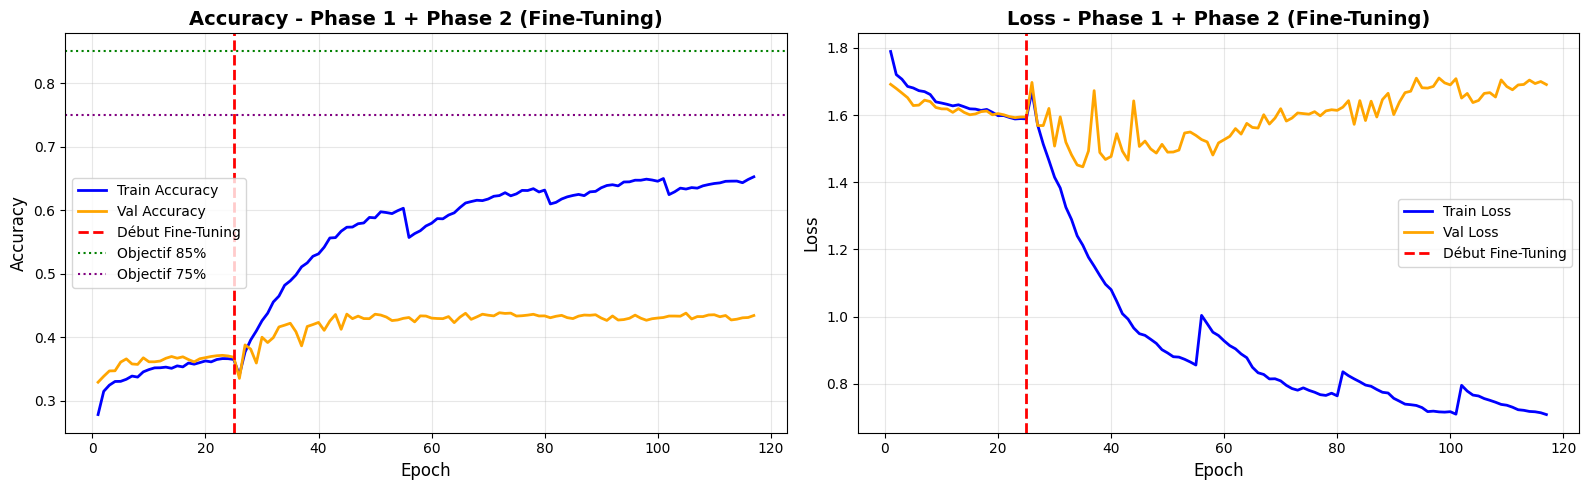

✅ Graphique sauvegardé: training_complete_history.png
✅ Historique complet sauvegardé: history_complete.csv


In [16]:
print("\n📊 Création des graphiques...")

# Combiner les historiques de toutes les phases
combined_accuracy_train = history_phase1.history['accuracy']
combined_accuracy_val = history_phase1.history['val_accuracy']
combined_loss_train = history_phase1.history['loss']
combined_loss_val = history_phase1.history['val_loss']

# Ajouter les phases supplémentaires si elles existent
if 'all_histories' in globals():
    for phase_key in sorted(all_histories.keys()):
        if phase_key != 'phase1':
            phase_history = all_histories[phase_key]
            combined_accuracy_train += phase_history.history['accuracy']
            combined_accuracy_val += phase_history.history['val_accuracy']
            combined_loss_train += phase_history.history['loss']
            combined_loss_val += phase_history.history['val_loss']
else:
    # Fallback : juste Phase 1 + Phase 2
    combined_accuracy_train += history_phase2.history['accuracy']
    combined_accuracy_val += history_phase2.history['val_accuracy']
    combined_loss_train += history_phase2.history['loss']
    combined_loss_val += history_phase2.history['val_loss']

total_epochs = len(combined_accuracy_train)

# Créer les graphiques
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy
axes[0].plot(range(1, total_epochs+1), combined_accuracy_train, 
             label='Train Accuracy', linewidth=2, color='blue')
axes[0].plot(range(1, total_epochs+1), combined_accuracy_val, 
             label='Val Accuracy', linewidth=2, color='orange')
axes[0].axvline(x=INITIAL_EPOCHS, color='red', linestyle='--', 
                linewidth=2, label='Début Fine-Tuning')
axes[0].axhline(y=0.85, color='green', linestyle=':', 
                linewidth=1.5, label='Objectif 85%')
axes[0].axhline(y=TARGET_ACCURACY, color='purple', linestyle=':', 
                linewidth=1.5, label=f'Objectif {TARGET_ACCURACY*100:.0f}%')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy - Phase 1 + Phase 2 (Fine-Tuning)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(range(1, total_epochs+1), combined_loss_train, 
             label='Train Loss', linewidth=2, color='blue')
axes[1].plot(range(1, total_epochs+1), combined_loss_val, 
             label='Val Loss', linewidth=2, color='orange')
axes[1].axvline(x=INITIAL_EPOCHS, color='red', linestyle='--', 
                linewidth=2, label='Début Fine-Tuning')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss - Phase 1 + Phase 2 (Fine-Tuning)', 
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "training_complete_history.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Graphique sauvegardé: training_complete_history.png")

# Sauvegarder aussi les historiques combinés en CSV
combined_history = pd.DataFrame({
    'epoch': range(1, total_epochs+1),
    'accuracy': combined_accuracy_train,
    'val_accuracy': combined_accuracy_val,
    'loss': combined_loss_train,
    'val_loss': combined_loss_val,
})
combined_history.to_csv(OUTPUT_DIR / "history_complete.csv", index=False)
print(f"✅ Historique complet sauvegardé: history_complete.csv")


## Vérification Des Fichiers Créés


In [17]:
files_to_check = [
    "best_model_finetuned.h5",
    "model_phase1_best.h5",
    "model_phase1_final.h5",
    "history_phase1.csv",
    "history_phase2.csv",
    "history_complete.csv",
    "training_complete_history.png",
    "data_config.json",
]

print("\n📦 Fichiers dans /kaggle/working/:\n")
for filename in files_to_check:
    filepath = OUTPUT_DIR / filename
    if filepath.exists():
        size_mb = filepath.stat().st_size / (1024 * 1024)
        print(f"✅ {filename:35s} ({size_mb:.2f} MB)")
    else:
        print(f"❌ {filename:35s} (MANQUANT)")

print("\n" + "=" * 80)
print("✅ ENTRAÎNEMENT COMPLET TERMINÉ !")
print("=" * 80)
print("\n💾 FICHIER À TÉLÉCHARGER :")
print("   → best_model_finetuned.h5  (Le meilleur modèle avec fine-tuning)")
print("\n💡 Ce fichier contient le modèle prêt pour la production")
print("   Placez-le dans models/ sur votre PC local")
print("=" * 80)



📦 Fichiers dans /kaggle/working/:

✅ best_model_finetuned.h5             (27.96 MB)
✅ model_phase1_best.h5                (12.75 MB)
✅ model_phase1_final.h5               (12.75 MB)
✅ history_phase1.csv                  (0.00 MB)
✅ history_phase2.csv                  (0.00 MB)
✅ history_complete.csv                (0.01 MB)
✅ training_complete_history.png       (0.14 MB)
✅ data_config.json                    (0.00 MB)

✅ ENTRAÎNEMENT COMPLET TERMINÉ !

💾 FICHIER À TÉLÉCHARGER :
   → best_model_finetuned.h5  (Le meilleur modèle avec fine-tuning)

💡 Ce fichier contient le modèle prêt pour la production
   Placez-le dans models/ sur votre PC local


## Résumé Final Et Prochaines Étapes


In [18]:
print("\n" + "=" * 80)
print("🎉 ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS")
print("=" * 80)

print(f"\n📊 RÉSULTATS FINAUX:")
print(f"   Val Accuracy: {phase2_val_acc:.4f} ({phase2_val_acc*100:.2f}%)")
if phase2_top3 > 0:
    print(f"   Top-3 Accuracy: {phase2_top3:.4f} ({phase2_top3*100:.2f}%)")
print(f"   Val Loss: {phase2_val_loss:.4f}")

print(f"\n📈 PROGRESSION:")
print(f"   Phase 1 (base gelée): {phase1_val_acc*100:.2f}%")
print(f"   Phase 2 (fine-tuning): {phase2_val_acc*100:.2f}%")
print(f"   Amélioration: +{(phase2_val_acc - phase1_val_acc)*100:.2f}%")

print(f"\n🎯 ÉVALUATION:")
if phase2_val_acc >= 0.85:
    status = "✅ EXCELLENT - Déploiement recommandé"
elif phase2_val_acc >= 0.75:
    status = "✅ BON - Objectif atteint"
elif phase2_val_acc >= 0.65:
    status = "⚠️  ACCEPTABLE - Utilisable en production"
else:
    status = "❌ INSUFFISANT - Réentraîner avec ajustements"

print(f"   {status}")

print(f"\n📥 PROCHAINES ÉTAPES:")
print("   1. Télécharger 'best_model_finetuned.h5' depuis Kaggle Output")
print("   2. Télécharger 'data_config.json' (contient les noms de classes)")
print("   3. Placer ces fichiers dans models/ de votre projet local")
print("   4. Continuer avec l'évaluation détaillée (Étape 5)")
print("   5. Créer l'API Flask/FastAPI")
print("   6. Déployer en production")

print("\n" + "=" * 80)
print("Félicitations ! 🎊 Votre modèle est prêt !")
print("=" * 80)



🎉 ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS

📊 RÉSULTATS FINAUX:
   Val Accuracy: 0.4377 (43.77%)
   Top-3 Accuracy: 0.9624 (96.24%)
   Val Loss: 1.6436

📈 PROGRESSION:
   Phase 1 (base gelée): 37.12%
   Phase 2 (fine-tuning): 43.77%
   Amélioration: +6.65%

🎯 ÉVALUATION:
   ❌ INSUFFISANT - Réentraîner avec ajustements

📥 PROCHAINES ÉTAPES:
   1. Télécharger 'best_model_finetuned.h5' depuis Kaggle Output
   2. Télécharger 'data_config.json' (contient les noms de classes)
   3. Placer ces fichiers dans models/ de votre projet local
   4. Continuer avec l'évaluation détaillée (Étape 5)
   5. Créer l'API Flask/FastAPI
   6. Déployer en production

Félicitations ! 🎊 Votre modèle est prêt !
